In [14]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# import tensorflow and tensorboard
import tensorflow as tf
from tensorflow import keras
import tensorboard

# Helper libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


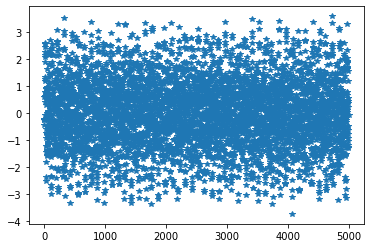

In [15]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm =  np.arange(0, (num_train_data+num_test_data)*timestep, timestep);
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2)) 

SNR = 10
ypn = y + np.random.normal(0,10**(-SNR/20),len(y))
plt.plot(ypn,'*')
plt.show()

In [16]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
  train_data = np.concatenate((train_data,ypn[k:k+dnn_numinputs]));
  num_train_batch = num_train_batch + 1  
train_data = np.reshape(train_data, (num_train_batch,dnn_numinputs))
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]

In [17]:
def dnn_keras_model():
  model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
  model.summary()
  return model
print(tf.__version__)
tensorboard.__version__
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

2.5.0


In [18]:
EPOCHS = 100
model = dnn_keras_model()
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[tensorboard_callback])
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()
print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")
#plt.plot(history.epoch,np.array(history.history['val_loss']),label='Val loss')
#plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  21.858181 s


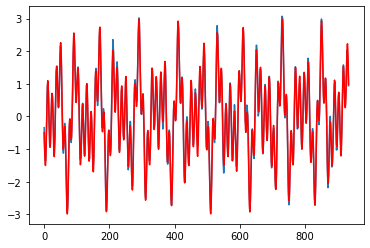

In [19]:
# test how well DNN predicts now
num_test_batch = 0
strt_idx = num_train_batch
test_data=[]
for k in range(strt_idx, strt_idx+num_test_data-dnn_numinputs-1):
  test_data = np.concatenate((test_data,ypn[k:k+dnn_numinputs]));
  num_test_batch = num_test_batch + 1  
test_data = np.reshape(test_data, (num_test_batch, dnn_numinputs))
test_labels = y[strt_idx+dnn_numinputs:strt_idx+num_test_batch+dnn_numinputs]
dnn_predictions = model.predict(test_data).flatten()
keras_dnn_err = test_labels - dnn_predictions
plt.plot(dnn_predictions)
plt.plot(test_labels,'r')
plt.show()

In [20]:
# Let us look at CNN next
cnn_numinputs = 16 
num_cnn_features = 1
train_data = []
cnn_train_batch = 0

# prepare training data
for k in range(num_train_data-cnn_numinputs-1):
  train_data = np.concatenate((train_data,ypn[k:k+cnn_numinputs]));
  cnn_train_batch = cnn_train_batch + 1  
train_data = np.reshape(train_data, (cnn_train_batch,cnn_numinputs,num_cnn_features))
train_labels = y[cnn_numinputs:cnn_train_batch+cnn_numinputs]

# define the model
def cnn_keras_model():
  # use 4 tap conv. filter and process each set of input samples 3 times (i.e., 3 different filters)
  # this means each input sample will create 3 such sample 
  # Max pooling then picks 4 out of this 12 resulting in 3 samples for each input sample
  # this goes to a Dense layer that provides 16 outputs, 
  # followed by another dense layer that provides 1 output 
  model = keras.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=4, activation='tanh', 
                    input_shape=(train_data.shape[1],train_data.shape[2])))
  model.add(tf.keras.layers.AveragePooling1D(pool_size=4))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  return model

# train the model
EPOCHS = 100
model = cnn_keras_model()
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
cnn_train_time = timedelta.total_seconds()
print("CNN training done. Time elapsed: ", timedelta.total_seconds(), "s")                  
#plt.plot(history.epoch,np.array(history.history['val_loss']),label='Val loss')
#plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 3)             15        
_________________________________________________________________
average_pooling1d_1 (Average (None, 3, 3)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________
CNN training done. Time elapsed:  41.297903 s


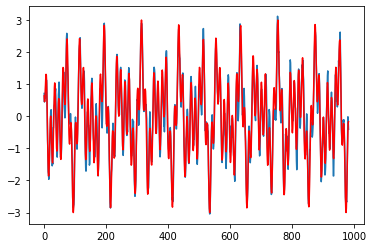

In [21]:
# test how well CNN predicts now
test_data = []
cnn_test_batch = 0
for k in range(num_test_data-cnn_numinputs-1):
  test_data = np.concatenate((test_data,ypn[k:k+cnn_numinputs]));
  cnn_test_batch = cnn_test_batch + 1  
test_data = np.reshape(test_data, (cnn_test_batch,cnn_numinputs,num_cnn_features))
test_labels = y[cnn_numinputs:cnn_test_batch+cnn_numinputs]
cnn_predictions = model.predict(test_data).flatten()
keras_cnn_err = test_labels - cnn_predictions
plt.plot(cnn_predictions)
plt.plot(test_labels,'r')
plt.show()

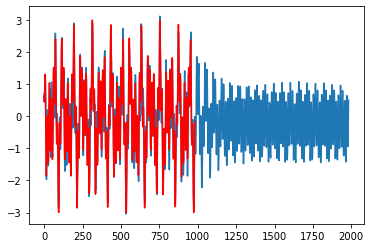

In [22]:
#continue running CNN based on its own output
for k in range(1000):
  fb_data = np.reshape(cnn_predictions[len(cnn_predictions)-cnn_numinputs:],(1,cnn_numinputs,num_cnn_features))
  new_pred = model.predict(fb_data).flatten()
  cnn_predictions = np.concatenate((cnn_predictions, new_pred))
plt.plot(cnn_predictions)
plt.plot(test_labels,'r')
plt.show()

In [23]:
lstm_numinputs = 8
lstm_lookback = 4
train_data = []
lstm_train_batch = 0

# generate train data
for k in range(num_train_data-(lstm_numinputs*lstm_lookback)-1):
  train_data = np.concatenate((train_data,ypn[k:k+(lstm_lookback*lstm_numinputs)]));
  lstm_train_batch = lstm_train_batch + 1
train_data = np.reshape(train_data, (lstm_train_batch,lstm_lookback,lstm_numinputs))
train_labels = y[(lstm_lookback*lstm_numinputs):(lstm_lookback*lstm_numinputs)+lstm_train_batch]

# define LSTM model
def lstm_keras_model():
  model = keras.Sequential([
    tf.keras.layers.LSTM(16, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],train_data.shape[2])),
    keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
  model.summary()
  return model

# train LSTM model
EPOCHS = 100
model = lstm_keras_model()
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
lstm_train_time = timedelta.total_seconds()
print("LSTM training done. Time elapsed: ", timedelta.total_seconds(), "s")
#plt.plot(history.epoch,np.array(history.history['val_loss']),label='Val loss')
#plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________
LSTM training done. Time elapsed:  79.21134 s


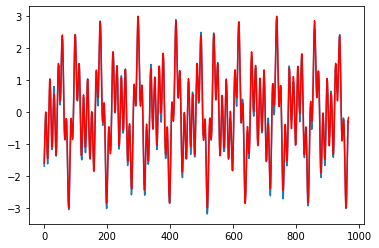

In [24]:
# test how well LSTM predicts now
test_data = []
lstm_test_batch = 0
for k in range(num_test_data-(lstm_numinputs*lstm_lookback)-1):
  test_data = np.concatenate((test_data,ypn[k:k+(lstm_lookback*lstm_numinputs)]))
  lstm_test_batch = lstm_test_batch + 1
test_data = np.reshape(test_data, (lstm_test_batch,lstm_lookback,lstm_numinputs))
test_labels = y[(lstm_lookback*lstm_numinputs):(lstm_lookback*lstm_numinputs)+lstm_test_batch]
lstm_predictions = model.predict(test_data).flatten()
keras_lstm_err = test_labels - lstm_predictions
plt.plot(lstm_predictions)
plt.plot(test_labels,'r')
plt.show()

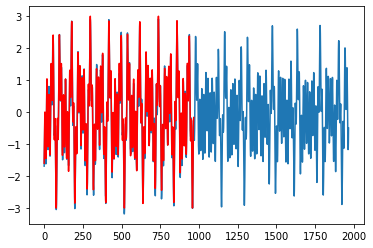

In [25]:
#continue running LSTM based on its own output
for k in range(1000):
  fb_data = np.reshape(lstm_predictions[len(lstm_predictions)-(lstm_lookback*lstm_numinputs):],(1,lstm_lookback,lstm_numinputs))
  new_pred = model.predict(fb_data).flatten()
  lstm_predictions = np.concatenate((lstm_predictions, new_pred))
plt.plot(lstm_predictions)
plt.plot(test_labels,'r')
plt.show()

In [29]:
#%tensorboard --logdir logs

In [27]:
#plt.plot(dnn_predictions[1000:1200])
#plt.plot(lstm_predictions[1000+8:1200],'r')
#plt.show()
mse_dnn = np.mean(pow(keras_dnn_err,2))
mse_cnn = np.mean(pow(keras_cnn_err,2))
mse_lstm = np.mean(pow(keras_lstm_err,2))
print("MSE for DNN, CNN and LSTM: ", mse_dnn, mse_cnn, mse_lstm)

MSE for DNN, CNN and LSTM:  0.016395556566605265 0.08842663334702622 0.023254483270294456


In [28]:
# Summary of training run time
print("DNN training time: ", dnn_train_time, "s")
print("CNN training time: ", cnn_train_time, "s")
print("LSTM training time: ", lstm_train_time, "s")

DNN training time:  21.858181 s
CNN training time:  41.297903 s
LSTM training time:  79.21134 s
